####  Imports

In [1]:
%%bash
# pip install wheel pandas matplotlib plotly wandb autohash 
# export WANDB_NOTEBOOK_NAME='data_preprocessing'

#### Init W&B 

In [2]:
import wandb
wandb.init(project="anomaly-detection-idc")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adielm (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-09-23 11:58:36.637261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-23 11:58:36.637290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys
import torch
import ipaddress
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
import sys
module_path = sys.path.append('/home/ubuntu/nabu/anomaly_detection/src')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data import *
# from helpers import *

# Data Preprocessing

In [5]:
DATA = Path('../data')
ALL_DATA_PATH = DATA / 'global_sh2.json'
MALICIOUS_PATH = DATA / 'global_sh23.08.json'


# Configs

In [6]:
# Split to train and test
SPLIT_DATE = pd.to_datetime('2021-07-31')

# features to exclude
DROP_COLS = ['protocol', 'data', 'public_proxy', 'raw_data'] 

# categorical features we want to target encode frequency based
ENCODE_CAT_FREQ = ['country', 'sensor_id', 'port']  

# most common groups encoding
N_TOP = 10 
ENCODE_CAT_COMMON_GROUPS = ['country']

# 1. Feature Encoding


In [7]:
#### FUNCTIONS ######

def create_aggs(df_all):
    # Aggregation based on session id 
    grouped = df_all.sort_values(by='ts').groupby('session_id')
    df_all['agg_session_id_row_count'] = grouped.cumcount()+1
    df_all['agg_session_id_packet_size_sum'] = grouped['packet_size'].cumsum()
    df_all['agg_session_id_packet_size_max'] = grouped['packet_size'].cummax()
    df_all['agg_session_id_packet_size_min'] = grouped['packet_size'].cummin()
    df_all['agg_session_id_packet_size_mean'] = grouped.expanding()['packet_size'].mean().reset_index(level=0, drop=True)
    df_all['agg_session_id_packet_size_std'] = grouped.expanding()['packet_size'].std().reset_index(level=0, drop=True)


    # Aggregation based on the same ip and the same day
    df_all['date'] = df_all['ts'].dt.date
    df_all['agg_ip_row_count'] = df_all.sort_values(by='ts').groupby(['ip', 'date']).cumcount()+1
    df_all.drop('date', axis=1, inplace=True)
    
    return df_all


def encode_n_most_common(df: pd.DataFrame, col: str , top_labels: list) -> pd.DataFrame:
    ''' top_labels is given as the list to map by. 
     N_TOP most common are labeled and others as other group
     then, encode as dummy variable'''
    
#     if top_labels is None:
#         top_labels = df[col].value_counts().nlargest(n_top).keys()
    df[f'{col}_most_common_enc'] = np.where(df[col].isin(top_labels), df[col], 'other')
    # Dummy Encoding
    df = pd.concat([df, pd.get_dummies(df[f'{col}_most_common_enc'])], axis=1)
    del df['other'], df[f'{col}_most_common_enc']
    return df
    
def mapping_to_numeric_freq_based(df: pd.DataFrame, cols_to_encode: list):
    '''create encoding to numeric of categorical variables based on occurance frequency
    returns dictionary with the mapping'''
    mapping_dic = {} 
    for col in cols_to_encode:       
        sorted_indices = df[col].value_counts().index
        mapping_dic[col] = dict(zip(sorted_indices, range(1, len(sorted_indices)+1)))
    return mapping_dic
    
    
def transform_mapping(df: pd.DataFrame, mapping_dic: dict):
    '''encode to numeric categorical based on given mapping
    returns the df with cols encoded'''
    cols_to_encode = mapping_dic.keys()
    for col in cols_to_encode:       
        df.loc[:,col] = df[col].map(mapping_dic[col])
    return df    
    
    
    
def port_to_dummy_bits(df: pd.DataFrame) -> pd.DataFrame:
    df_tmp = df.apply(lambda i: pd.Series([int(b) for b in format(int(i['port']), '016b')], dtype='int8'), axis=1)
    df_tmp.columns = df_tmp.columns.map(lambda bit_idx: f'port_bit_{bit_idx}')
    return pd.concat([df, df_tmp], axis=1)

In [10]:
df = load_data(ALL_DATA_PATH)

parsing raws:   0%|          | 0/1648904 [00:00<?, ?it/s]

In [15]:
df.shape
df.head()
df.columns
df.ts.min(), df.ts.max()

(1648904, 13)

,_id,session_id,sensor_id,protocol,port,ip,data,ts,country,public_proxy,tor,packet_size,raw_data
0,60e3347be9809b72a5b0d334,ec892c1a-e1cc-45ea-8040-ced7bef29d87,44f231a130a17ef5d5184dcbaf6f762fbb10bc01,tcp,1433,111.122.172.149,EgEANAAAAAAAABUABgEAGwABAgAcAAwDACgABP8IAAFVAA...,2021-07-05T16:34:03.312Z,CN,False,False,52.0,EgEANAAAAAAAABUABgEAGwABAgAcAAwDACgABP8IAAFVAA...
1,60e3347be9809b72a5b0d335,45827df4-fc6c-42c3-b8a8-07ca7c39fee6,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,59.125.225.176,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05T16:34:03.367Z,TW,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...
2,60e3347be9809b72a5b0d336,d8b6b5bf-fead-483c-b205-b1ba082661c8,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,45.146.167.35,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05T16:34:03.423Z,RU,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...
3,60e3347be9809b72a5b0d337,01c99580-ca72-43a0-9b8e-27c2560543a0,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,185.219.52.83,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05T16:34:03.478Z,PL,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...
4,60e3347be9809b72a5b0d338,bc2b1527-6edf-48f1-9b9a-3d5129c698c7,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,62.94.72.8,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05T16:34:03.536Z,IT,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...


Index(['_id', 'session_id', 'sensor_id', 'protocol', 'port', 'ip', 'data',
       'ts', 'country', 'public_proxy', 'tor', 'packet_size', 'raw_data'],
      dtype='object')

('2021-07-05T16:34:03.312Z', '2021-08-02T14:43:48.935Z')

# Loading Data and PreProcessing

In [ ]:
df_mal = (load_data(MALICIOUS_PATH)
          # remove cols
          .pipe(drop_columns, cols_names=DROP_COLS)
          # optimizing memory
          .pipe(optimize_memory))

df_all = (load_data(ALL_DATA_PATH)
          # remove cols
          .pipe(drop_columns, cols_names=DROP_COLS)
          # optimizing memory
          .pipe(optimize_memory)
          # add the labels (normal and attack)
          .pipe(add_labels, malicious_ids=df_mal._id.unique())
          # Handle missing values
          .pipe(handle_missing, missing={'country': 'other', 'packet_size': 0})
          # Create feature aggregations
          .pipe(create_aggs)
          # Encode IP
          .pipe(ipv4_to_dummy_bits)
          # Encode Port
          .pipe(port_to_dummy_bits)
          # As in the paper: (ip and time_val)
          .pipe(based_paper_preprocess))




parsing raws:   0%|          | 0/1075 [00:00<?, ?it/s]

memory usage reduced from 535412 to 235176


parsing raws:   0%|          | 0/1648904 [00:00<?, ?it/s]

memory usage reduced from 821079323 to 337226280


In [19]:

# Split to Train-Test
df_train, df_test = split_by_date(df_all, SPLIT_DATE)

# Encode Categorical Variables Based on Train Set:

# Encode to N Most Common Groups:
for col in ENCODE_CAT_COMMON_GROUPS:
    top_labels = df_train[col].value_counts().nlargest(N_TOP).keys()
    df_train = encode_n_most_common(df_train, col, top_labels)
    df_test = encode_n_most_common(df_test, col, top_labels)
print('finish encode most common groups')

# Frequency Based:
# Create mapping
mapping = df_train.pipe(mapping_to_numeric_freq_based, cols_to_encode = ENCODE_CAT_FREQ)
# Transform the mapping
df_train = df_train.pipe(transform_mapping, mapping)
df_test = df_test.pipe(transform_mapping, mapping)
print('finish encode frequency based')



Splitting data to Train set with 1,365,979 rows and Validation set with 282,925 rows.      
With 82.84% - 17.16% ratio


/tmp/ipykernel_862/605878998.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_most_common_enc'] = np.where(df[col].isin(top_labels), df[col], 'other')


finish encode most common groups
finish encode frequency based


In [49]:
# tor nad identify to binary

df_train['identify'] = df_train['identify'].astype(int)
df_test['identify'] = df_test['identify'].astype(int)

df_train['tor'] = df_train['tor'].astype(int)
df_test['tor'] = df_test['tor'].astype(int)

df_train['agg_session_id_packet_size_std'].fillna(0, inplace=True)
df_test['agg_session_id_packet_size_std'].fillna(0, inplace=True)

# Temp:  additional features

In [21]:
DATA = Path('../data')
TRAIN_DATASET = DATA / 'train_data.csv'
TEST_DATASET = DATA / 'test_data.csv'

df_train = pd.read_csv(TRAIN_DATASET.resolve())
df_test = pd.read_csv(TEST_DATASET.resolve())

df_train.shape
df_test.shape

(1365979, 75)

(282925, 75)

### NEW FEATURES

In [22]:
df = pd.concat([df_train, df_test])
          # As in the paper: (ip and time_val)
    
df.ts = pd.to_datetime(df.ts)
df = df.pipe(based_paper_preprocess)

In [25]:
## TemM

ENCODE_CAT_FREQ = ['sensor_id', 'port'] # additional

# Split to Train-Test
df_train, df_test = split_by_date(df_all, SPLIT_DATE)

# Encode Categorical Variables Based on Train Set:


# Frequency Based:
# Create mapping
mapping = df_train.pipe(mapping_to_numeric_freq_based, cols_to_encode = ENCODE_CAT_FREQ)
# Transform the mapping
df_train = df_train.pipe(transform_mapping, mapping)
df_test = df_test.pipe(transform_mapping, mapping)
print('finish encode frequency based')



Splitting data to Train set with 1,365,979 rows and Validation set with 282,925 rows.      
With 82.84% - 17.16% ratio
finish encode frequency based


/home/ubuntu/pyenv/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Saving data

In [46]:
# Save Mapping

import json

json.dump(mapping, open('../outputs/frequency_based_encoding.json', 'w'))

top_labels_mapping = list(top_labels)
top_labels_mapping.sort()
json.dump(top_labels_mapping, open('../outputs/most_common_based_encoding.json', 'w'))


In [27]:
# write prepared dataset clean
df_train.to_csv(DATA / 'train_data.csv', index=False)

# write prepared dataset malicious
df_test.to_csv(DATA / 'test_data.csv', index=False)

### Done!

# Read data for EDA

In [60]:
import pandas_profiling as pp
SELECTED_FEATURES = [
       'sensor_id', 
       'packet_size',   'ip_bit_0',
       'ip_bit_1', 'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6',
       'ip_bit_7', 'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11',
       'ip_bit_12', 'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16',
       'ip_bit_17', 'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21',
       'ip_bit_22', 'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26',
       'ip_bit_27', 'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31',
       'port_bit_0', 'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4',
       'port_bit_5', 'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9',
       'port_bit_10', 'port_bit_11', 'port_bit_12', 'port_bit_13',
       'port_bit_14', 'port_bit_15',
    'country',
    'tor', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count',
'identify']

df = pd.concat([df_train[SELECTED_FEATURES], df_test[SELECTED_FEATURES]])

df['identify'] = df['identify'].astype('category')
df['tor'] = df['tor'].astype('category')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648904 entries, 0 to 1648903
Data columns (total 60 columns):
 #   Column                           Non-Null Count    Dtype   
---  ------                           --------------    -----   
 0   sensor_id                        1648904 non-null  category
 1   packet_size                      1648904 non-null  float64 
 2   ip_bit_0                         1648904 non-null  int8    
 3   ip_bit_1                         1648904 non-null  int8    
 4   ip_bit_2                         1648904 non-null  int8    
 5   ip_bit_3                         1648904 non-null  int8    
 6   ip_bit_4                         1648904 non-null  int8    
 7   ip_bit_5                         1648904 non-null  int8    
 8   ip_bit_6                         1648904 non-null  int8    
 9   ip_bit_7                         1648904 non-null  int8    
 10  ip_bit_8                         1648904 non-null  int8    
 11  ip_bit_9                         1648

In [6]:
DATA = Path('../data')
TRAIN_DATASET = DATA / 'train_data.csv'
TEST_DATASET = DATA / 'test_data.csv'

df_train = pd.read_csv(TRAIN_DATASET.resolve())
df_test = pd.read_csv(TEST_DATASET.resolve())

In [16]:
df_train.columns

Index(['_id', 'session_id', 'sensor_id', 'port', 'ip', 'ts', 'country', 'tor',
       'packet_size', 'identify', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count', 'ip_bit_0',
       'ip_bit_1', 'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6',
       'ip_bit_7', 'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11',
       'ip_bit_12', 'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16',
       'ip_bit_17', 'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21',
       'ip_bit_22', 'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26',
       'ip_bit_27', 'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31',
       'port_bit_0', 'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4',
       'port_bit_5', 'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9',
       'port_bit_10', 'port_bit_11', 'port_bi

In [19]:
cols= ['session_id', 'sensor_id', 'port', 'ip', 'ts', 'country', 'tor',
       'packet_size', 'identify', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count']

df_train[df_train.session_id=='1f45041f-9f70-4567-b206-179d9f2ab7fe'][cols]

ip = '218.94.34.54'
df_train[df_train.ip==ip][cols]

,session_id,sensor_id,port,ip,ts,country,tor,packet_size,identify,agg_session_id_row_count,agg_session_id_packet_size_sum,agg_session_id_packet_size_max,agg_session_id_packet_size_min,agg_session_id_packet_size_mean,agg_session_id_packet_size_std,agg_ip_row_count
1365972,1f45041f-9f70-4567-b206-179d9f2ab7fe,1,3389,218.94.34.54,2021-07-30 23:12:55.840000+00:00,2,0,42.0,0,1,42.0,42.0,42.0,42.0,0.000000,307
1365978,1f45041f-9f70-4567-b206-179d9f2ab7fe,1,3389,218.94.34.54,2021-07-30 23:13:06.252000+00:00,2,0,46.0,0,2,88.0,46.0,42.0,44.0,2.828427,310


,session_id,sensor_id,port,ip,ts,country,tor,packet_size,identify,agg_session_id_row_count,agg_session_id_packet_size_sum,agg_session_id_packet_size_max,agg_session_id_packet_size_min,agg_session_id_packet_size_mean,agg_session_id_packet_size_std,agg_ip_row_count
59,0aa147e3-77f2-4184-aa21-309b1a28df30,147,3389,218.94.34.54,2021-07-05 16:34:14.043000+00:00,2,0,42.0,0,1,42.0,42.0,42.0,42.000000,0.000000,1
60,f4b1a945-648e-4150-a761-a4870677793f,63,3389,218.94.34.54,2021-07-05 16:34:14.108000+00:00,2,0,42.0,0,1,42.0,42.0,42.0,42.000000,0.000000,2
96,baf786ad-51fb-442e-b25a-0e8bf82850c3,46,3389,218.94.34.54,2021-07-05 16:34:23.536000+00:00,2,0,42.0,0,1,42.0,42.0,42.0,42.000000,0.000000,3
98,600de912-1e8f-4742-8fa2-a229a9487eea,58,3389,218.94.34.54,2021-07-05 16:34:23.720000+00:00,2,0,37.0,0,1,37.0,37.0,37.0,37.000000,0.000000,4
99,600de912-1e8f-4742-8fa2-a229a9487eea,58,3389,218.94.34.54,2021-07-05 16:34:23.783000+00:00,2,0,9.0,0,2,46.0,37.0,9.0,23.000000,19.798990,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365971,aff21105-7eda-43bb-b27c-28818ba8c01e,38,3389,218.94.34.54,2021-07-30 23:12:51.629000+00:00,2,0,9.0,0,3,88.0,42.0,9.0,29.333333,17.785762,306
1365972,1f45041f-9f70-4567-b206-179d9f2ab7fe,1,3389,218.94.34.54,2021-07-30 23:12:55.840000+00:00,2,0,42.0,0,1,42.0,42.0,42.0,42.000000,0.000000,307
1365974,b462282e-df3c-4bf1-ac7a-528753d6ce41,54,3389,218.94.34.54,2021-07-30 23:13:00.011000+00:00,2,0,46.0,0,2,88.0,46.0,42.0,44.000000,2.828427,308
1365977,f7913416-2c06-49f8-a9f6-2269bf26f9c1,6,3389,218.94.34.54,2021-07-30 23:13:05.227000+00:00,2,0,42.0,0,1,42.0,42.0,42.0,42.000000,0.000000,309


In [32]:
df_train.columns

[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/numpy/matrixlib/__init__.py", line 6, in <module>
    __all__ = defmatrix.__all__
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.lib failed: Trac

Index(['_id', 'session_id', 'sensor_id', 'port', 'ip', 'ts', 'country', 'tor',
       'packet_size', 'identify', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count', 'ip_bit_0',
       'ip_bit_1', 'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6',
       'ip_bit_7', 'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11',
       'ip_bit_12', 'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16',
       'ip_bit_17', 'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21',
       'ip_bit_22', 'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26',
       'ip_bit_27', 'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31',
       'port_bit_0', 'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4',
       'port_bit_5', 'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9',
       'port_bit_10', 'port_bit_11', 'port_bi

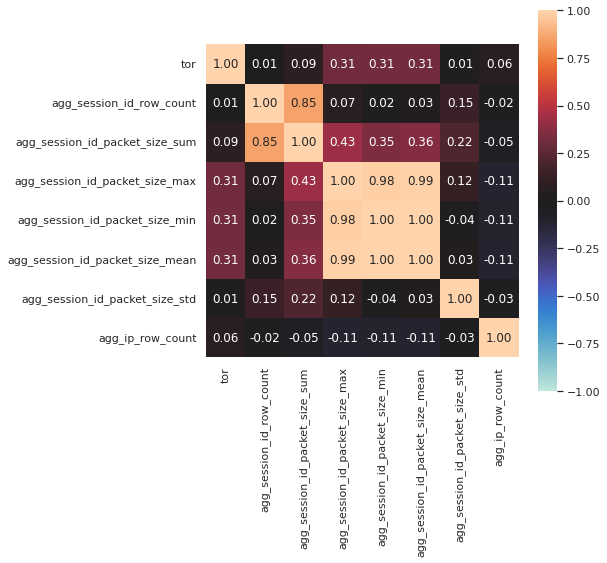

{'corr':                                       tor  agg_session_id_row_count  \
 tor                              1.000000                  0.006370   
 agg_session_id_row_count         0.006370                  1.000000   
 agg_session_id_packet_size_sum   0.091112                  0.851726   
 agg_session_id_packet_size_max   0.308679                  0.067079   
 agg_session_id_packet_size_min   0.314160                  0.018318   
 agg_session_id_packet_size_mean  0.313762                  0.030900   
 agg_session_id_packet_size_std   0.008081                  0.147807   
 agg_ip_row_count                 0.063472                 -0.024178   
 
                                  agg_session_id_packet_size_sum  \
 tor                                                    0.091112   
 agg_session_id_row_count                               0.851726   
 agg_session_id_packet_size_sum                         1.000000   
 agg_session_id_packet_size_max                         0.427260   
 a

In [29]:
# import plotly.figure_factory as ff
to_show = ['tor', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count']

df = pd.concat([df_train, df_test])[to_show]
# sns.heatmap(df.corr(), annot = True, fmt='.1g')

from dython.nominal import associations
sns.set(rc={'figure.figsize':(7,7)})
associations(df, nominal_columns=['country','tor','identify'])

In [30]:
to_remove = ['agg_session_id_packet_size_mean', 'agg_session_id_packet_size_min']
for elem in to_remove:
    to_show.remove(elem)

In [39]:
df.head()

TypeError: int() argument must be a string, a bytes-like object or a number, not '_NoValueType'

,tor,agg_session_id_row_count,agg_session_id_packet_size_sum,agg_session_id_packet_size_max,agg_session_id_packet_size_min,agg_session_id_packet_size_mean,agg_session_id_packet_size_std,agg_ip_row_count
0,0,1,52.0,52.0,52.0,52.0,0.0,1
1,0,1,43.0,43.0,43.0,43.0,0.0,1
2,0,1,43.0,43.0,43.0,43.0,0.0,1
3,0,1,43.0,43.0,43.0,43.0,0.0,1
4,0,1,43.0,43.0,43.0,43.0,0.0,1


In [41]:
to_show = ['ip_bit_0',
       'ip_bit_1', 'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6',
       'ip_bit_7', 'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11',
       'ip_bit_12', 'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16',
       'ip_bit_17', 'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21',
       'ip_bit_22', 'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26',
       'ip_bit_27', 'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31',
       'port_bit_0', 'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4',
       'port_bit_5', 'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9',
       'port_bit_10', 'port_bit_11', 'port_bit_12', 'port_bit_13',
       'port_bit_14', 'port_bit_15','identify']
# df_sub = df[to_show]
associations(df[to_show], nominal_columns=['identify'])

TypeError: int() argument must be a string, a bytes-like object or a number, not '_NoValueType'